## Helpers

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

In [28]:
from dataclasses import dataclass
from typing import Tuple, List

from dataclasses_json import DataClassJsonMixin


@dataclass(frozen=True)
class BoundingBox(DataClassJsonMixin):
    left_top: Tuple[int, int]
    right_bottom: Tuple[int, int]


@dataclass
class DetectedFace(DataClassJsonMixin):
    bounding_box: BoundingBox
    confidence: float
    landmarks: List[Tuple[int, int]]


@dataclass
class DetectedFaces(DataClassJsonMixin):
    inference_results: List[DetectedFace]

## Visualisation

In [38]:
def draw_predictions(
    image: np.ndarray,
    predictions: DetectedFaces
) -> np.ndarray:
    image = image.copy()
    for prediction in predictions.inference_results:
        bbox = prediction.bounding_box
        cv.rectangle(
            img=image,
            pt1=bbox.left_top,
            pt2=bbox.right_bottom,
            color=(0, 255, 0),
            thickness=5
        )
        image = draw_keypoints(image=image, keypoints=prediction.landmarks)
    return image

def draw_keypoints(
    image: np.ndarray,
    keypoints: List[Tuple[int, int]]
) -> np.ndarray:
    for point in keypoints:
        cv.circle(image, point, 4, (255,0,0), -1)
    return image

## Client

In [31]:
import numpy as np
import requests
import time

GATEWAY_URL = "http://127.0.0.1:50000/maas_workshop/v2/gateway/detect_faces"

def detect_faces(image: np.ndarray, login: str) -> DetectedFaces:
    resource_identifier = initialize_request(image=image, login=login)
    return fetch_results(login=login, resource_identifier=resource_identifier)

def initialize_request(image: np.ndarray, login: str) -> str:
    raw_image = image_to_jpeg_bytes(image=image)
    files = {'image': raw_image}
    init_response = requests.post(GATEWAY_URL, data={"login": login}, files=files)
    if init_response.status_code == 200:
        return init_response.json()["resource_identifier"]
    else:
        raise RuntimeError(
            f'Error code while initialization: {response.status_code}, Cause: {response.text}'
        )

        
def fetch_results(login: str, resource_identifier: str) -> DetectedFaces:
    while True:
        print("Trying to fetch response...")
        fetch_response = requests.get(
            GATEWAY_URL, 
            data={"login": login, "resource_identifier": resource_identifier}
        )
        if fetch_response.status_code != 200:
            raise RuntimeError(
                f'Error code while fetching: {response.status_code}, Cause: {response.text}'
            )
        result = fetch_response.json()
        if "status" in result and result["status"] == "in_progress":
            time.sleep(0.5)
        else:
            return DetectedFaces.from_dict(result)
        

def image_to_jpeg_bytes(
    image: np.ndarray,
    compression_rate: int = 90
) -> bytes:
    if compression_rate <= 0 or compression_rate > 100:
        raise ValueError("Compression rate must be in range (0; 100]")
    encode_param = [int(cv.IMWRITE_JPEG_QUALITY), compression_rate]
    _, raw_image = cv.imencode('.jpg', image, encode_param)
    return raw_image

## Demo

In [6]:
from glob import glob

IMAGES_PATHS = glob("../data/object_detection/*")

In [7]:
IMAGE = cv.imread(IMAGES_PATHS[2])[:, :, ::-1]

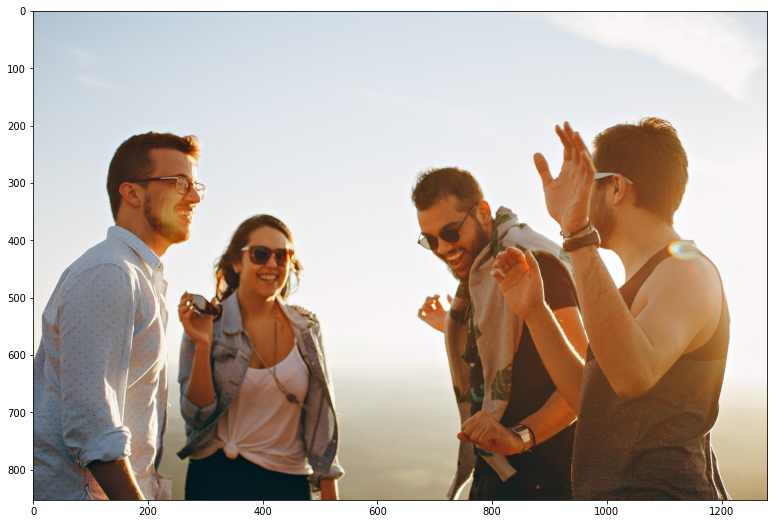

In [8]:
plt.imshow(IMAGE)

In [32]:
INFERENCE_RESULTS = detect_faces(image=IMAGE, login="dummy")

Trying to fetch response...
Trying to fetch response...
Trying to fetch response...
Trying to fetch response...
Trying to fetch response...
Trying to fetch response...
Trying to fetch response...
Trying to fetch response...
Trying to fetch response...
Trying to fetch response...


In [33]:
INFERENCE_RESULTS

DetectedFaces(inference_results=[DetectedFace(bounding_box=BoundingBox(left_top=(668, 333), right_bottom=(783, 468)), confidence=0.9998674392700195, landmarks=[(694, 401), (726, 384), (712, 425), (724, 437), (754, 422)]), DetectedFace(bounding_box=BoundingBox(left_top=(191, 253), right_bottom=(292, 400)), confidence=0.9997856020927429, landmarks=[(260, 302), (277, 307), (291, 329), (250, 351), (269, 356)]), DetectedFace(bounding_box=BoundingBox(left_top=(364, 381), right_bottom=(447, 498)), confidence=0.9987459182739258, landmarks=[(397, 424), (433, 427), (419, 446), (392, 462), (427, 465)])])

In [39]:
VISUALISATION_RESULTS = draw_predictions(
    image=IMAGE,
    predictions=INFERENCE_RESULTS
)

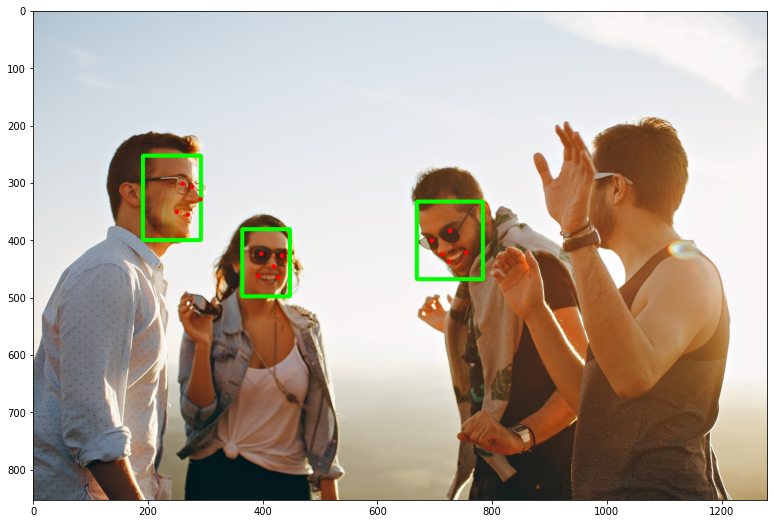

In [40]:
plt.imshow(VISUALISATION_RESULTS)